# PHASE 1
## EEG Data Setup

In [1]:
!pip install numpy scipy matplotlib


In [4]:
import scipy.io
import os

# Load the .mat file
file_path = os.path.join('MAT', 'G_S0023_M1_E0_R8_N1_raw_ref.mat')
mat_data = scipy.io.loadmat(file_path)

# Show all keys in the file
print("Keys in .mat file:", mat_data.keys())


Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'Data'])


In [6]:
eeg_signal = mat_data['Data']  # Replace 'eeg' with your actual key
print("EEG shape:", eeg_signal.shape)


EEG shape: (6, 16000)


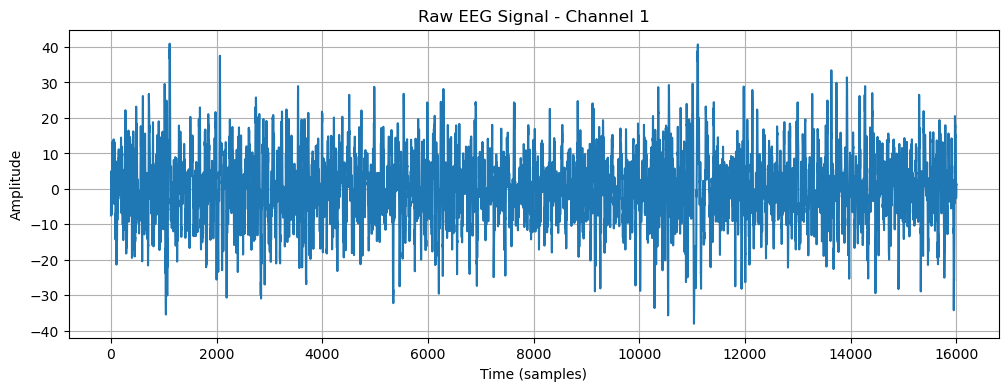

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(eeg_signal[0])  # First channel
plt.title("Raw EEG Signal - Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [8]:
with open('data/eeg_summary.txt', 'w') as f:
    f.write(f"EEG shape: {eeg_signal.shape}\n")
    f.write("Channels: {}\n".format(eeg_signal.shape[0]))
    f.write("Timepoints: {}\n".format(eeg_signal.shape[1]))

print("Summary saved to data/eeg_summary.txt")


Summary saved to data/eeg_summary.txt


# PHASE 2
## preprocessing

In [9]:
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import os


In [11]:
# Load your EEG file
mat_data = scipy.io.loadmat('G_S0023_M1_E0_R8_N1_raw_ref.mat')

# Replace 'eeg' with the actual key from your file
eeg_signal = mat_data['Data']  # Shape: (channels, timepoints)
print("EEG shape:", eeg_signal.shape)


EEG shape: (6, 16000)


In [12]:
def bandpass_filter(data, lowcut=1, highcut=45, fs=200, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply filter to each channel
fs = 200  # Sampling rate
filtered_eeg = np.array([bandpass_filter(channel, fs=fs) for channel in eeg_signal])
print("Filtered EEG shape:", filtered_eeg.shape)


Filtered EEG shape: (6, 16000)


In [13]:
segment_length = 2 * fs  # 400 samples
total_length = filtered_eeg.shape[1]

segments = []
for start in range(0, total_length - segment_length + 1, segment_length):
    end = start + segment_length
    segment = filtered_eeg[:, start:end]
    segments.append(segment)

segments = np.array(segments)  # Shape: (num_segments, channels, segment_length)
print("Segmented EEG shape:", segments.shape)


Segmented EEG shape: (40, 6, 400)


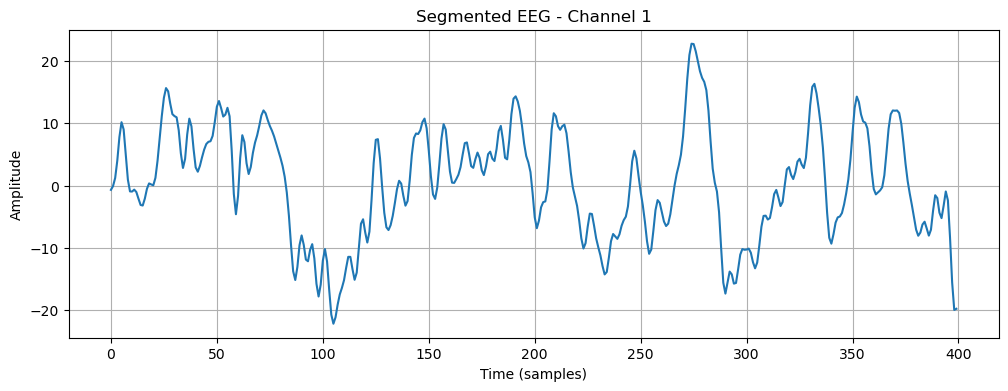

In [14]:
# Plot first channel of the first segment
plt.figure(figsize=(12, 4))
plt.plot(segments[0][0])  # First segment, first channel
plt.title("Segmented EEG - Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [15]:
np.save('data/subject01_segments.npy', segments)
print("Segments saved to data/subject01_segments.npy")


Segments saved to data/subject01_segments.npy


# PHASE 3
## Feature Extraction

In [16]:
import numpy as np

# Load the segments saved in Phase 2
segments = np.load('data/subject01_segments.npy')
print("Segments shape:", segments.shape)  # (num_segments, channels, segment_length)


Segments shape: (40, 6, 400)


In [17]:
from scipy.signal import welch

# Define frequency bands
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

def extract_psd_features(segment, fs=200):
    features = []
    for channel in segment:
        freqs, psd = welch(channel, fs=fs)
        for band in bands.values():
            idx = np.logical_and(freqs >= band[0], freqs <= band[1])
            band_power = np.sum(psd[idx])
            features.append(band_power)
    return features

# Apply to all segments
psd_features = [extract_psd_features(seg) for seg in segments]
psd_features = np.array(psd_features)
print("PSD Features shape:", psd_features.shape)


PSD Features shape: (40, 30)


In [18]:
import pywt

def extract_dwt_features(segment, wavelet='db4', level=4):
    features = []
    for channel in segment:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        for c in coeffs:
            features.extend([
                np.mean(c),
                np.std(c),
                np.max(c),
                np.min(c)
            ])
    return features

# Apply to all segments
dwt_features = [extract_dwt_features(seg) for seg in segments]
dwt_features = np.array(dwt_features)
print("DWT Features shape:", dwt_features.shape)


DWT Features shape: (40, 120)


In [19]:
# Combine PSD and DWT features
combined_features = np.hstack((psd_features, dwt_features))
print("Combined Features shape:", combined_features.shape)

# Save for future use
np.save('data/subject01_features.npy', combined_features)
print("Features saved to data/subject01_features.npy")


Combined Features shape: (40, 150)
Features saved to data/subject01_features.npy


# PHASE 4 
## Unsupervised Modeling

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [21]:
# Load features saved in Phase 3
features = np.load('data/subject01_features.npy')
print("Features shape:", features.shape)  # (num_segments, num_features)


Features shape: (40, 150)


In [22]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [23]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.15920487 0.09241034]


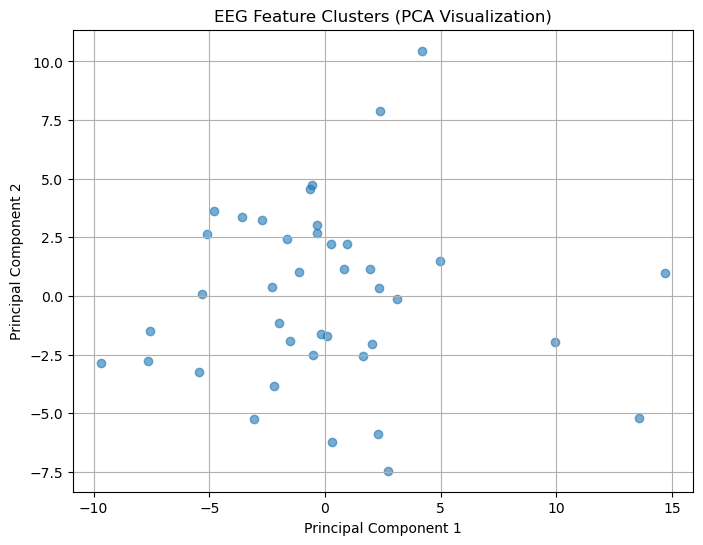

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.6)
plt.title("EEG Feature Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [25]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

print("Cluster labels:", cluster_labels[:10])


Cluster labels: [1 2 0 1 2 0 2 0 2 2]


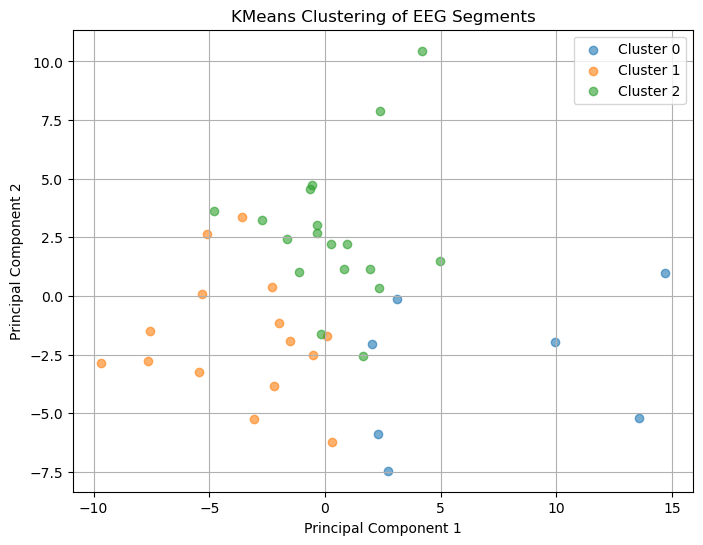

In [26]:
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    idx = cluster_labels == cluster
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("KMeans Clustering of EEG Segments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
np.save('data/subject01_clusters.npy', cluster_labels)
print("Cluster labels saved to data/subject01_clusters.npy")


Cluster labels saved to data/subject01_clusters.npy


# PHASE 5
## Evaluation & Optimization

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [29]:
features = np.load('data/subject01_features.npy')
print("Features shape:", features.shape)


Features shape: (40, 150)


In [30]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [31]:
scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")


Clusters: 2, Silhouette Score: 0.2156
Clusters: 3, Silhouette Score: 0.0427
Clusters: 4, Silhouette Score: 0.0405
Clusters: 5, Silhouette Score: 0.0419
Clusters: 6, Silhouette Score: 0.0507
Clusters: 7, Silhouette Score: 0.0298
Clusters: 8, Silhouette Score: 0.0510
Clusters: 9, Silhouette Score: 0.0395


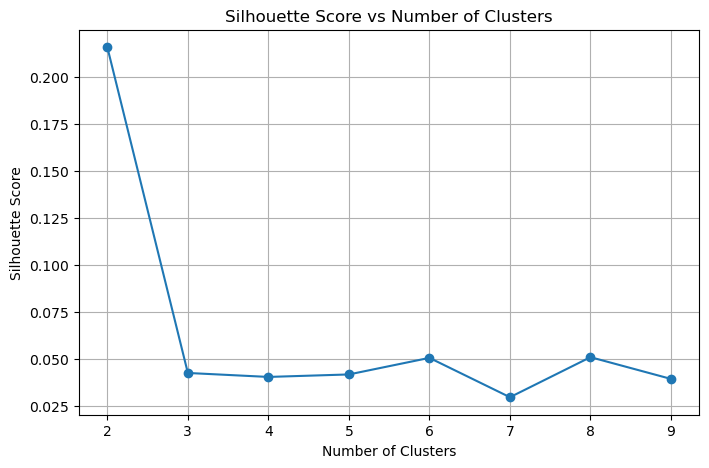

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [33]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)


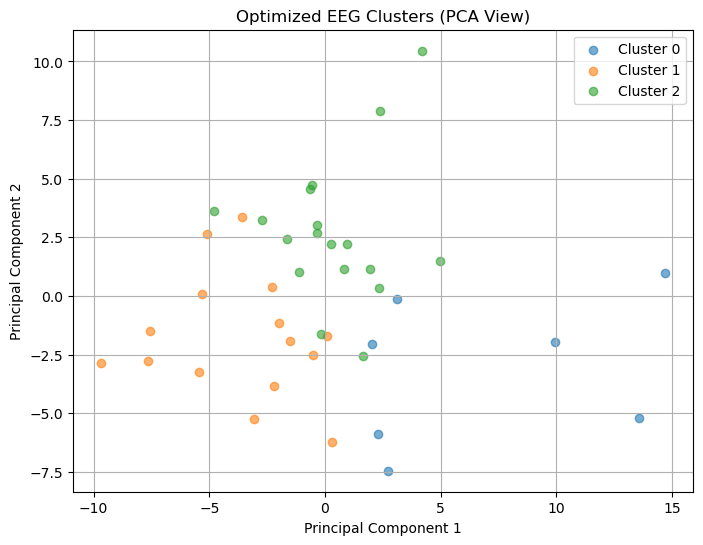

In [34]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    idx = cluster_labels == cluster
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Optimized EEG Clusters (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
np.save('data/subject01_optimized_clusters.npy', cluster_labels)
print("Optimized cluster labels saved.")


Optimized cluster labels saved.


# PHASE 6
## final

In [36]:
import numpy as np

# Load features and cluster labels
features = np.load('data/subject01_features.npy')
clusters = np.load('data/subject01_optimized_clusters.npy')

print("Features shape:", features.shape)
print("Cluster labels shape:", clusters.shape)


Features shape: (40, 150)
Cluster labels shape: (40,)


In [37]:
import pandas as pd

# Combine features and cluster labels
summary_df = pd.DataFrame(features)
summary_df['Cluster'] = clusters

# Show basic stats
print("Cluster counts:")
print(summary_df['Cluster'].value_counts())

# Save summary
summary_df.to_csv('results/subject01_cluster_summary.csv', index=False)
print("Summary saved to results/subject01_cluster_summary.csv")


Cluster counts:
2    18
1    15
0     7
Name: Cluster, dtype: int64
Summary saved to results/subject01_cluster_summary.csv


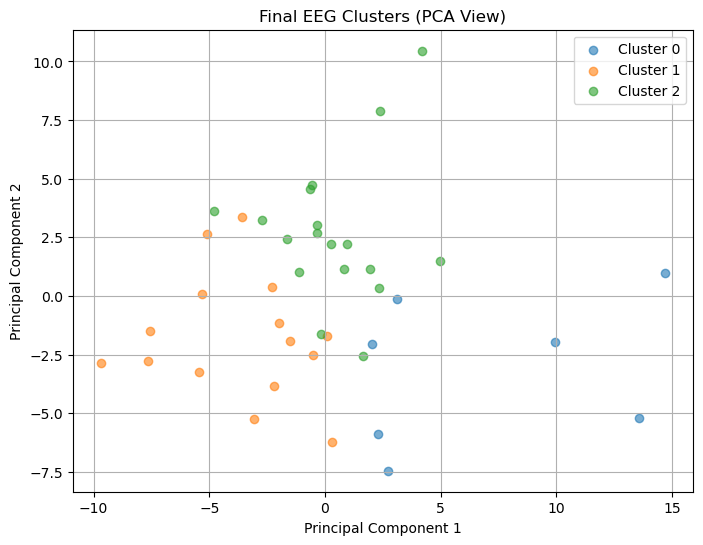

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize and reduce to 2D
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot and save
plt.figure(figsize=(8, 6))
for cluster in np.unique(clusters):
    idx = clusters == cluster
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Final EEG Clusters (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.savefig('results/final_clusters_plot.png')
plt.show()


# Dream emotion analysis 

In [44]:
import numpy as np

# Load cluster labels (from Phase 5)
clusters = np.load('data/subject01_optimized_clusters.npy')



In [45]:
unique, counts = np.unique(clusters, return_counts=True)
emotion_summary = dict(zip(unique, counts))
print("Segment counts per cluster:", emotion_summary)


Segment counts per cluster: {0: 7, 1: 15, 2: 18}


In [46]:
cluster_emotions = {
    0: "Calm",
    1: "Anxious",
    2: "Vivid/Excited"
}


In [47]:
summary_lines = []
total_segments = len(clusters)

summary_lines.append("🛌 Dream Emotion Summary:")
summary_lines.append(f"Total EEG segments analyzed: {total_segments}\n")

for cluster_id, count in emotion_summary.items():
    emotion = cluster_emotions.get(cluster_id, "Unknown")
    percentage = (count / total_segments) * 100
    summary_lines.append(f"- {emotion} ({cluster_id}): {count} segments ({percentage:.1f}%)")

# Print the summary
print("\n".join(summary_lines))


🛌 Dream Emotion Summary:
Total EEG segments analyzed: 40

- Calm (0): 7 segments (17.5%)
- Anxious (1): 15 segments (37.5%)
- Vivid/Excited (2): 18 segments (45.0%)


In [52]:
!pip install matplotlib



In [53]:
%matplotlib inline


In [54]:
import numpy as np

# Load your cluster labels
clusters = np.load('data/subject01_optimized_clusters.npy')
print("Total segments:", len(clusters))
print("First 10 cluster labels:", clusters[:10])


Total segments: 40
First 10 cluster labels: [1 2 0 1 2 0 2 0 2 2]


In [55]:
# Define your emotion mapping
emotion_map = {
    0: "Calm",
    1: "Anxious",
    2: "Vivid/Excited"
}


In [56]:
# Count segments per cluster
unique, counts = np.unique(clusters, return_counts=True)
total = len(clusters)

# Print summary
print("🛌 Dream Emotion Summary:")
for cluster_id, count in zip(unique, counts):
    emotion = emotion_map.get(cluster_id, f"Cluster {cluster_id}")
    percentage = (count / total) * 100
    print(f"- {emotion}: {count} segments ({percentage:.1f}%)")


🛌 Dream Emotion Summary:
- Calm: 7 segments (17.5%)
- Anxious: 15 segments (37.5%)
- Vivid/Excited: 18 segments (45.0%)


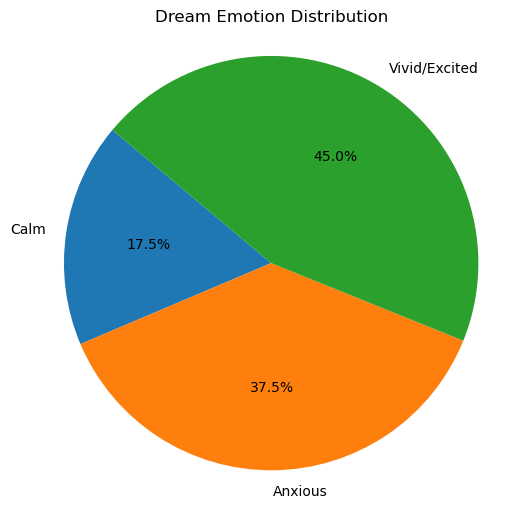

In [57]:
import matplotlib.pyplot as plt

labels = [emotion_map.get(cid, f"Cluster {cid}") for cid in unique]
sizes = [(count / total) * 100 for count in counts]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Dream Emotion Distribution")
plt.axis('equal')
plt.show()


# Final summarization


In [62]:
import numpy as np

def generate_dream_summary(cluster_file, emotion_map):
    # Load cluster labels
    clusters = np.load(cluster_file)
    total_segments = len(clusters)

    # Count segments per cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    # Identify dominant emotion
    dominant_cluster = max(cluster_counts, key=cluster_counts.get)
    dominant_emotion = emotion_map.get(dominant_cluster, f"Cluster {dominant_cluster}")
    dominant_count = cluster_counts[dominant_cluster]
    dominant_percent = (dominant_count / total_segments) * 100

    # Start summary
    summary = f"🛌 Dream Emotion Summary\n\n"
    summary += f"The dream was primarily characterized by **{dominant_emotion}**, appearing in {dominant_count} out of {total_segments} EEG segments ({dominant_percent:.1f}%).\n"

    # Add other emotions
    for cluster_id, count in cluster_counts.items():
        if cluster_id == dominant_cluster:
            continue
        emotion = emotion_map.get(cluster_id, f"Cluster {cluster_id}")
        percent = (count / total_segments) * 100
        summary += f"- {emotion} was present in {count} segments ({percent:.1f}%)\n"

    # Add closing reflection
    summary += "\nThis emotional landscape suggests a dream that shifted between different mental states, possibly reflecting subconscious thoughts, feelings, or memories."

    return summary



In [63]:
# Define your emotion mapping
emotion_map = {
    0: "Calm",
    1: "Anxious",
    2: "Vivid/Excited"
}

# Generate summary
summary_text = generate_dream_summary('data/subject01_optimized_clusters.npy', emotion_map)
print(summary_text)

🛌 Dream Emotion Summary

The dream was primarily characterized by **Vivid/Excited**, appearing in 18 out of 40 EEG segments (45.0%).
- Calm was present in 7 segments (17.5%)
- Anxious was present in 15 segments (37.5%)

This emotional landscape suggests a dream that shifted between different mental states, possibly reflecting subconscious thoughts, feelings, or memories.


In [69]:
import numpy as np

def generate_fantasy_dream_story(cluster_file, emotion_map):
    # Load cluster labels
    clusters = np.load(cluster_file)
    total_segments = len(clusters)

    # Count segments per cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    # Sort clusters by frequency
    sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)

    # Build story elements
    story = "🌌✨ **Dream Chronicle: The Night of Wandering Echoes** ✨🌌\n\n"
    story += "As sleep embraced the dreamer, the mind slipped into a realm untouched by daylight.\n"

    for i, (cluster_id, count) in enumerate(sorted_clusters):
        emotion = emotion_map.get(cluster_id, f"Emotion {cluster_id}")
        
        if i == 0:
            story += f"The journey began in the land of **{emotion}**, where thoughts drifted like mist over moonlit meadows.\n"
        elif i == 1:
            story += f"But soon, the dream twisted — revealing the realm of **{emotion}**, where colors sharpened and memories danced with electric wonder.\n"
        else:
            story += f"Briefly, the dream wandered through shadows of **{emotion}**, a fleeting echo of something deeper, perhaps forgotten.\n"

    story += "\nAnd just as gently as it began, the dream softened once more. The vividness dimmed. The tension dissolved. The dreamer returned to the glade — weightless, still, and wrapped in silence."

    return story



In [70]:
emotion_map = {
    0: "Calm Meadows",
    1: "Storm of Worry",
    2: "Vivid Realms"
}

story = generate_fantasy_dream_story('data/subject01_optimized_clusters.npy', emotion_map)
print(story)




🌌✨ **Dream Chronicle: The Night of Wandering Echoes** ✨🌌

As sleep embraced the dreamer, the mind slipped into a realm untouched by daylight.
The journey began in the land of **Vivid Realms**, where thoughts drifted like mist over moonlit meadows.
But soon, the dream twisted — revealing the realm of **Storm of Worry**, where colors sharpened and memories danced with electric wonder.
Briefly, the dream wandered through shadows of **Calm Meadows**, a fleeting echo of something deeper, perhaps forgotten.

And just as gently as it began, the dream softened once more. The vividness dimmed. The tension dissolved. The dreamer returned to the glade — weightless, still, and wrapped in silence.


In [74]:
import numpy as np

def generate_human_dream_summary(cluster_file, emotion_map):
    clusters = np.load(cluster_file)
    total_segments = len(clusters)

    # Count segments per cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    # Sort clusters by frequency
    sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)

    # Build realistic summary
    summary = "📝 **Dream Reflection**\n\n"
    summary += "I don’t remember every detail, but the emotional tone of the dream lingered.\n"

    for i, (cluster_id, count) in enumerate(sorted_clusters):
        emotion = emotion_map.get(cluster_id, f"Emotion {cluster_id}")

        if i == 0:
            summary += f"There was a strong sense of **{emotion}** throughout — it felt like the dream was shaped by that emotion from beginning to end.\n"
        elif i == 1:
            summary += f"At certain points, I felt a shift — moments of **{emotion}** that stood out, like scenes that carried more weight or intensity.\n"
        else:
            summary += f"Some fragments were harder to place, but I sensed traces of **{emotion}**, maybe in the background or in transitions between scenes.\n"

    summary += "\nIt wasn’t a chaotic dream, but it wasn’t entirely peaceful either. It felt layered — like my mind was sorting through emotions quietly, without words."

    return summary



In [75]:
emotion_map = {
    0: "calm",
    1: "anxiety",
    2: "vivid excitement"
}

summary = generate_human_dream_summary('data/subject01_optimized_clusters.npy', emotion_map)
print(summary)



📝 **Dream Reflection**

I don’t remember every detail, but the emotional tone of the dream lingered.
There was a strong sense of **vivid excitement** throughout — it felt like the dream was shaped by that emotion from beginning to end.
At certain points, I felt a shift — moments of **anxiety** that stood out, like scenes that carried more weight or intensity.
Some fragments were harder to place, but I sensed traces of **calm**, maybe in the background or in transitions between scenes.

It wasn’t a chaotic dream, but it wasn’t entirely peaceful either. It felt layered — like my mind was sorting through emotions quietly, without words.


In [76]:
import numpy as np

def generate_unique_dream_story(subject_id, cluster_file, emotion_map):
    clusters = np.load(cluster_file)
    total_segments = len(clusters)

    # Count segments per cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    # Sort clusters by frequency
    sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)

    # Build story components
    dominant_cluster = sorted_clusters[0][0]
    dominant_emotion = emotion_map.get(dominant_cluster, f"Emotion {dominant_cluster}")

    secondary_emotions = []
    for cluster_id, count in sorted_clusters[1:]:
        emotion = emotion_map.get(cluster_id, f"Emotion {cluster_id}")
        secondary_emotions.append(emotion)

    # Generate unique story
    story = f"🛌 **Subject {subject_id} – Dream Reflection** 🛌\n\n"
    story += f"Last night, Subject {subject_id} experienced a dream shaped primarily by a sense of **{dominant_emotion}**. "
    story += f"This emotion seemed to guide the flow of the dream — whether through peaceful scenes, vivid memories, or internal calm.\n\n"

    if secondary_emotions:
        story += f"Throughout the dream, moments of **{', '.join(secondary_emotions)}** surfaced. "
        story += "These emotional shifts may have reflected changes in scenery, mental stimulation, or subconscious tension.\n\n"

    story += "The dream felt layered — not chaotic, but emotionally textured. It may have been a quiet journey through thoughts and feelings, stitched together by memory and imagination."

    return story


In [78]:
emotion_map = {
    0: "calm",
    1: "vivid excitement",
    2: "anxiety",
    3: "confusion",
    4: "nostalgia"
}

subject_id = "01"
story = generate_unique_dream_story(subject_id, 'data/subject01_optimized_clusters.npy', emotion_map)
print(story)

🛌 **Subject 01 – Dream Reflection** 🛌

Last night, Subject 01 experienced a dream shaped primarily by a sense of **anxiety**. This emotion seemed to guide the flow of the dream — whether through peaceful scenes, vivid memories, or internal calm.

Throughout the dream, moments of **vivid excitement, calm** surfaced. These emotional shifts may have reflected changes in scenery, mental stimulation, or subconscious tension.

The dream felt layered — not chaotic, but emotionally textured. It may have been a quiet journey through thoughts and feelings, stitched together by memory and imagination.
